In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import re
import torch
import numpy as np
from code_15780 import *
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # optional, I use this for monitoring progress
from torch.nn import Module, Parameter, ModuleList
import torch.nn.functional as F

In [5]:
### Load the data with a tokenizer (tokenizing it twice, not that efficient)
tokenizer = SimpleTokenizer("pg100.txt", lowercase=False)
with open("pg100.txt", "rt",encoding="utf8") as f:
    content = f.read()

# for simplicity, force train/test to be an even multiple of seq_len
seq_len = 256
tokens = tokenizer.encode(content)
tokens_train = tokens[:int(len(tokens)*0.7)]
tokens_train = tokens_train[:(len(tokens_train)//seq_len)*seq_len]

tokens_val = tokens[int(len(tokens)*0.7):]
tokens_val = tokens_val[:(len(tokens_val)//seq_len)*seq_len]

In [6]:
class TransformerBlockPreNorm(Module):
    """ Single transformer block with attention plus a feedforward network"""
    def __init__(self, d,heads,d_ff):
        super().__init__()
        max_seq_length=256
        self.attn=SelfAttention(d, heads, max_seq_length)
        self.w1=Linear(d,d_ff)
        self.w2=Linear(d_ff,d)

        self.norm1=LayerNorm(d)
        self.norm2=LayerNorm(d)

        self.relu=ReLU()

    def forward(self,X,mask=None,use_kv_cache=False):
        Z=X+self.attn(self.norm1(X),mask,use_kv_cache)
        Y=Z+self.w2(self.relu(self.w1(self.norm2(Z))))
        return Y


In [7]:
class LanguageModel(Module):
    """ Complete language model that runs:
        - Embedding
        - Positional Encoding
        - Tranformer block layers
        - Output linear layer
    """
    def __init__(self, hidden_dim,seq_len,heads,ffn_dim,num_layers,vocab_size):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embed= Embedding(vocab_size, hidden_dim)
        self.position = PositionalEncoding(hidden_dim)
        layerList=[]
        for i in range(num_layers):
            layerList.append(TransformerBlockPreNorm(hidden_dim,heads,ffn_dim))
        self.layers=ModuleList(layerList)
        self.norm=LayerNorm(hidden_dim)

        self.last_layer=Linear(hidden_dim, vocab_size)

    def forward(self,X,use_kv_cache=False):
        B,T=X.shape[0],X.shape[1]
        
        X_hidden=torch.zeros(B,T,self.hidden_dim)
        for i in range(B):
            X_hidden[i] = self.embed(X[i])
        
        X_hidden = self.position(X_hidden)
        

        mask=torch.tril(torch.ones(T,T))
        mask=mask.masked_fill(mask==0,float('-inf'))

        for layer in self.layers:
            X_hidden=layer(X_hidden,mask,use_kv_cache)
        
        return self.last_layer(self.norm(X_hidden))

        

In [8]:
def epoch_transformer_lm(model, tokens, seq_len, opt=None, batch_size=5, verbose=True,use_kv_cache=False):
    """ Run an epoch of the linear language model on the sequence of tokens.  
    If opt = None then just compute the loss, otherwise update the parameters
    using the optimizer.

    Args:
        model: torch.Module - PyTorch LanguageModel instance 
        tokens: torch.tensor (int64) - sequence of tokens to eval/train on
        seq_len: sequence length to evaluate in Transformer blocks
        batch_size: int - number of elements in minibatch
        verbose: bool - flag if you want to print debug info

    Returns:
        losses: torch.tensor (float) - losses on each minibatch
    """
    losses=[]
    big_batch=seq_len*batch_size
    num_batches=tokens.shape[0]//big_batch
    for i in range(num_batches):
        #print(set.shape,num_batches)
        t=tokens[i*big_batch:(i+1)*big_batch]
        t=t.reshape(batch_size,seq_len)
        X=t[:,0:seq_len-1]
        targets=t[:,1:seq_len]
        H=model(X,use_kv_cache)
        loss=F.cross_entropy(H.reshape(-1,H.size(-1)),targets.reshape(-1))
        losses.append(loss)
        if opt is not None:
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        if verbose and i%10==0:
            print(f"Batch {i+1}/{num_batches},Loss: {loss.item()}")
    return losses

In [9]:
def sample_transformer_naive(model, tokens, max_context, num_tokens, temperature=0.6,use_kv_cache=True):
    for i in range(num_tokens):
        probs = torch.softmax(model(tokens[None,i:i+1],use_kv_cache)[0,-1] / temperature,-1)
        tokens = torch.cat([tokens, torch.multinomial(probs, 1)])
    return tokens

In [10]:
model = LanguageModel(128, seq_len, 8, 1024, 5, tokenizer.vocab_size)
#opt = optim.Adam(model.parameters(), lr=1e-3)
#print(model.parameters)
#opt = SGD(model.parameters(), lr=0.5)
opt= Adam(model.parameters(),lr=1e-3)
sum(p.numel() for p in model.parameters())


9892554

In [11]:
losses = epoch_transformer_lm(model, tokens_train, 256, opt=opt, batch_size=5, verbose=True)
with torch.no_grad():
    val_losses = epoch_transformer_lm(model, tokens_val, 256)
print(torch.mean(torch.tensor(val_losses)))

Batch 1/796,Loss: 11.415380477905273
Batch 11/796,Loss: 7.8107008934021
Batch 21/796,Loss: 7.034384250640869
Batch 31/796,Loss: 6.102675437927246
Batch 41/796,Loss: 5.970793724060059
Batch 51/796,Loss: 6.119251251220703
Batch 61/796,Loss: 5.86444616317749
Batch 71/796,Loss: 5.432727813720703
Batch 81/796,Loss: 5.776902198791504
Batch 91/796,Loss: 6.096746921539307
Batch 101/796,Loss: 5.488276481628418
Batch 111/796,Loss: 5.877074241638184
Batch 121/796,Loss: 5.439838886260986
Batch 131/796,Loss: 5.794480800628662
Batch 141/796,Loss: 5.760931491851807
Batch 151/796,Loss: 5.241267681121826
Batch 161/796,Loss: 5.6136884689331055
Batch 171/796,Loss: 5.787564277648926
Batch 181/796,Loss: 5.547308921813965
Batch 191/796,Loss: 5.718118667602539
Batch 201/796,Loss: 5.351916313171387
Batch 211/796,Loss: 6.448256015777588
Batch 221/796,Loss: 5.522362232208252
Batch 231/796,Loss: 5.377926826477051
Batch 241/796,Loss: 5.716333389282227
Batch 251/796,Loss: 5.689040660858154
Batch 261/796,Loss: 5.35

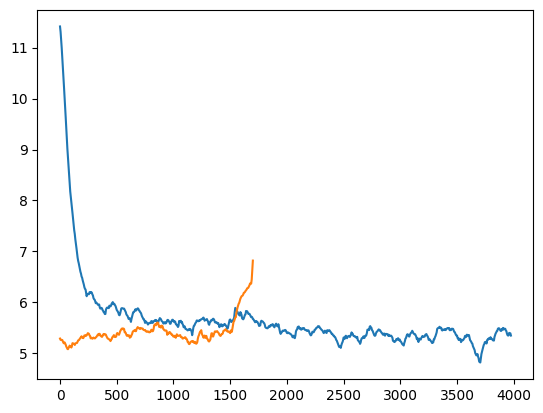

In [12]:
batch_size=5
plt.plot(np.arange(0,len(losses)*batch_size,batch_size),ema(torch.tensor(losses), beta=0.9))
plt.plot(np.arange(0,len(val_losses)*batch_size,batch_size),ema(torch.tensor(val_losses), beta=0.9))

In [14]:
t_out=sample_transformer_naive(model,tokens[20:30],seq_len,1000,0.6,use_kv_cache=True)
print(tokenizer.decode(t_out))

of anyone anywhere in the United States and
most your the the the Prince; noble, When of he
good presence the
,
I my. I time
King What
To. love
 do, To, a What,
.
.
.
king, and

For
 Let
 I,
death My For me
,


That. lord my, Enter and
That To world
, lord
to the The the?.
I. With the skill bargain truth

 And.
,,
..

 it
 To
I For



.
, To have, To
To That
 To
day my
a With one shores
. They, noble By Duke.,
IAGO
,

all


And, She a The So to For That To foul
,

of thy graves
the the That
And And these
, To my
full To that at.My
the lord My my. so. _ lord That King. lord heart But.
], King? If,
that
 I

.
the let The.
have
To
 I fellow. King
For not And of
do.

I..

That.

 That will
I To And thou
As
 not. With do the?, Take.
so
.. word

.
To



, KING And
It any For
 To
thou
it The,
,
the To, For.-for To
KING good on


. it it To _, my To Why To
.,,

lordship.
night



For That,
To, If[To And yet.
Your lies I thou when, my

 I my,.. the
father The
 do lord my

grace So are own
, the